# Optimizing the parameters of a ball-and-stick model

This exercise was done as part of the Simulation Neuroscience MOOC by EPFL. Most of the content was taken from the course with a couple of modifications written by yours truly. 

Copyright © 2005-2022 Blue Brain Project/EPFL. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.


In this tutorial you will learn how to:
- **Create** the cell model in BluePyOpt
- Create a **cell evaluator**
- Run a **parameter optimization**
- **Analyze** the results of the optimization

Let's install dependencies and load matplotlib (plotting library) first:

In [22]:
#Install dependencies
!pip install bluepyopt
!pip install neurom
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 7.6 MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

We **import BluePyOpt** and the submodule that contains all the functionality to create biophysically detailed electrical cell models

In [3]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys

Setting up the cell model
-------------------------
First a template that will describe the cell has to be defined. A template consists of:
* the shape of the cell (**morphology**)
* the description (equations) of the **ion channels** on the membrane (mechanisms)
* the **parameters** of the model

### Adding a morphology
The shape of a neuron is loaded from a file (SWC or ASC format). The description of the SWC format can be found [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).

Below you can see an SWC description of a morphology with a soma with a radius of 10 micron, and a single dendritic section with a length of 100 micron and a radius of 2 micron.

Let's write this to a file so that we can load it in [BluePyOpt](https://github.com/BlueBrain/BluePyOpt).

In [4]:
morph_swc_string = """
1 1 0.0 0.0 -10.0 10.0 -1                                                        
2 1 0.0 0.0 0.0 10.0 1                                                           
3 1 0.0 0.0 10.0 10.0 2                                                          
4 3 0.0 10.0 0.0 2.0 1                                                           
5 3 0.0 110.0 0.0 2.0 4
"""
with open('ballandstick.swc', 'w') as swc_file:
    swc_file.write(morph_swc_string)

Note from the SWC format, the string above is formatted with first column as indices indicating one of the following:

- 1: Soma
- 2: Axon
- 3: (Basal) Dendrite
- 4: (Apical) Dendrite
- 5: Fork point
- 6: End point
- 7: Custom

Succeeding columns indicate **x, y, z, (spatial coordinates) radius, parent sample number**



We can plot this morphology using the Neuronal Morphology Analysis Tool ([NeuroM](https://github.com/BlueBrain/NeuroM))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: NeuroMDeprecationWarning: `neurom.io.utils.load_neuron` is deprecated in favor of `neurom.io.utils.load_morphology`
  This is separate from the ipykernel package so we can avoid doing imports until


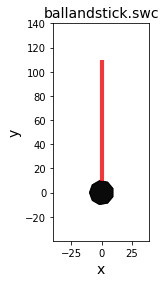

In [8]:
import neurom
import neurom.viewer
fig, ax = neurom.viewer.draw(neurom.load_neuron('ballandstick.swc'))

To use this morphology in BluePyOpt we create a NrnFileMorphology object

In [9]:
morph = ephys.morphologies.NrnFileMorphology('ballandstick.swc')

By default a Neuron morphology has the following section lists: somatic, axonal, apical and basal. Let's create Location objects that point to the somatic and basal sectionlist. This object will be used later to specify where mechanisms have to be added etc.

In [10]:
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')
dend_loc = ephys.locations.NrnSeclistLocation('basal', seclist_name='basal')

### Creating a mechanism

Now we need to specify which ion channels are present on the membrane of this morphology. The NEURON simulator has a builtin implementation of the [Hodgkin-Huxley](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model) **Sodium (Na), Potassium (K) and leak channels**. Let's add this mechanism (called 'hh') to the soma and dendrite. 

The 'name' field can be chosen by the user, this name should be unique. The 'suffix' points to the same [field](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/mechanisms/nmodl2.html#suffix) in the NMODL file of the channel. 'locations' specifies which sections the mechanism will be added to.

In [14]:
#Using the Hodgkin-Huxley Model
hh_mech = ephys.mechanisms.NrnMODMechanism(
        name='hh',
        suffix='hh',
        locations=[somatic_loc, dend_loc])


### Creating parameters

Next we need to specify the parameters of the model. A parameter can be in two states: **frozen and not-frozen**. When a parameter is frozen it has an exact value, otherwise it only has some bounds but the exact value is not known yet. Let's define first a parameter that sets the **specific capacitance** of soma and dendrites to a frozen value. 

In this tutorial we'll focus on optimizing the parameters the soma. So we also fix the **leakage conductance** of the dendrite, and we make it passive by disabling the Na and K conductances.

In [15]:
#Fix conductance as a frozen parameter
cm = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0, # in microfarad/cm2
        locations=[somatic_loc, dend_loc],
        frozen=True)

# Fix leak conductance dendrite
gl_dend = ephys.parameters.NrnSectionParameter(
        name='gl_dend',
        param_name='gl_hh',
        value=1e-5,
        locations=[dend_loc],
        frozen=True)

# Disable Na and K to make dendritic section passive (focus on optimizing soma)
gnabar_dend = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh_dend',
        param_name='gnabar_hh',
        locations=[dend_loc],
        value=0,
        frozen=True)     
gkbar_dend = ephys.parameters.NrnSectionParameter(
        name='gkbar_hh_dend',
        param_name='gkbar_hh',
        value=0,
        locations=[dend_loc],
        frozen=True)

Now we set the bounds for the **maximal conductances** of the sodium and potassium channels in the soma which are non-frozen parameters. These two parameters will be optimised later.

In [16]:
#Setting bounds for the non-frozen parameters to be optimized later
gnabar_soma = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_soma',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0.0, 1.0],
        frozen=False)     
gkbar_soma = ephys.parameters.NrnSectionParameter(
        name='gkbar_soma',
        param_name='gkbar_hh',
        bounds=[0.0, 1.0],
        locations=[somatic_loc],
        frozen=False)

### Creating the cell model

We put all the components (morphology, mechanisms, parameters) together into a CellModel.

In [17]:
ballandstick_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[cm, gnabar_dend, gkbar_dend, gl_dend, gnabar_soma, gkbar_soma])  

We can print out a description of the neuron:

In [18]:
print(ballandstick_cell)

simple_cell:
  morphology:
    ballandstick.swc
  mechanisms:
    hh: hh at ['somatic', 'basal']
  params:
    cm: ['somatic', 'basal'] cm = 1.0
    gnabar_hh_dend: ['basal'] gnabar_hh = 0
    gkbar_hh_dend: ['basal'] gkbar_hh = 0
    gl_dend: ['basal'] gl_hh = 1e-05
    gnabar_soma: ['somatic'] gnabar_hh = [0.0, 1.0]
    gkbar_soma: ['somatic'] gkbar_hh = [0.0, 1.0]



## Setting up a cell evaluator

To optimize the parameters of the cell we need to create an object that will translate parameter values into fitness scores.

This object will need to know which protocols to inject, which parameters to optimize, etc.

### Creating the protocols

A protocol consists of a set of stimuli, and a set of responses (i.e. recordings). These responses will later be used to calculate
the score of the parameter values.
Let's create two protocols, two square current pulses at somatic`[0]`(0.5) with different amplitudes.
We first need to create a location object

In [19]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

and then the stimuli, recordings and protocols. For each protocol we add a recording and a stimulus in the soma. The NrnSquarePulse stimulus represents a current clamp with a square current injection.

In [20]:
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.1), ('step2', 0.5)]:
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amplitude,
                step_delay=100,
                step_duration=50,
                location=soma_loc,
                total_duration=200)
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

### Running a protocol on a cell

Now we're at a stage where we can actually run a protocol on the cell. We first need to create a Simulator object (an abstraction of the NEURON simulator).

In [23]:
nrn = ephys.simulators.NrnSimulator()

The run() method of a protocol accepts a cell model, a set of parameter values and a simulator

In [24]:
default_params = {'gnabar_soma': 0.25, 'gkbar_soma': 0.1}

responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)

Plotting the response traces is now easy:

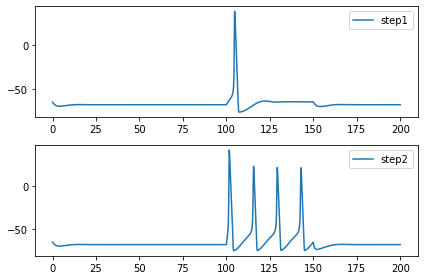

In [25]:
def plot_responses(responses):
    plt.subplot(2,1,1)
    plt.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='step1')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(responses['step2.soma.v']['time'], responses['step2.soma.v']['voltage'], label='step2')
    plt.legend()
    plt.tight_layout()

plot_responses(responses)

<div class="alert alert-block alert-warning">
<b>Info:</b> Although the plot above may differ from the one shown in the video, this has no effect on the exercise below.
</div>

As you can see, when we use different parameter values, the response looks different.

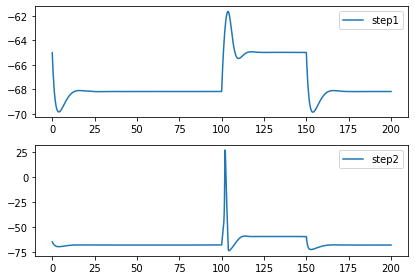

In [26]:
other_params = {'gnabar_soma': 0.1, 'gkbar_soma': 0.1}
plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=other_params, sim=nrn))

### Exercise 1:

Try to find a value of gnabar_soma (within bounds) that produces 3 spikes in the first trace and 5 traces in the second (Don't change gkbar_soma).

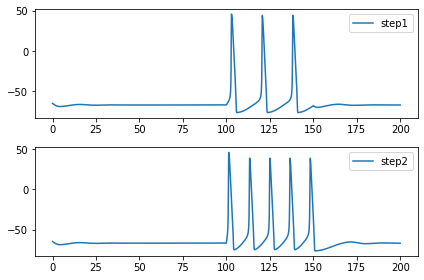

In [28]:
other_params = {'gnabar_soma': 0.5, 'gkbar_soma': 0.1}
plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=other_params, sim=nrn))

### Defining eFeatures and objectives

Instead of visually inspecting the traces, we can make use of eFEL (eFeature Extraction Library) to analyse the traces for us. This library can e.g. calculate the number of spikes in a trace, the height of these spikes, etc.

In [29]:
import efel

Number of spikes in 2nd trace: [4]
Spike widths (ms) in 2nd trace: [1.6 1.3 1.2 1.2]
Spike amplitude (mV) in 2nd trace: [108.01514787  72.86055421  71.75668666  70.65080624]


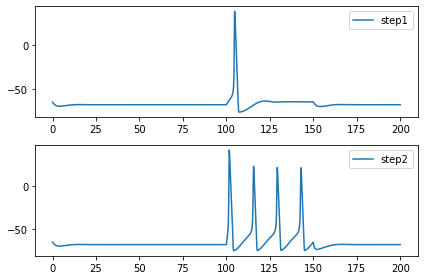

In [30]:
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=default_params, sim=nrn)

# Show where these names come from
step2_time = responses['step2.soma.v']['time']
step2_voltage = responses['step2.soma.v']['voltage']

# Define this dictionary
trace = {'T': step2_time, 'V': step2_voltage, 'stim_start': [100], 'stim_end': [150]}

# Get different features from the spikes or responses generated 
feature_values = efel.getFeatureValues([trace], ['Spikecount', 'AP_width', 'AP_amplitude'])[0]

plot_responses(responses)
print('Number of spikes in 2nd trace: %s' % feature_values['Spikecount'])
print('Spike widths (ms) in 2nd trace: %s' % feature_values['AP_width'])
print('Spike amplitude (mV) in 2nd trace: %s' % feature_values['AP_amplitude'])

Now we will, for every response, define a set of eFeatures we will use for the fitness calculation later. Let's use the SpikeCount feature: the first trace should have 1 spike, the second trace 5.

Different features can be combined together into objectives that will be used by the optimisation algorithm. In this case we will create one objective per feature.

Let's first set our goal. Let's ask for 4 spike in the first trace, and 6 spikes in the second trace:

In [31]:
efel_feature_means = {'step1': {'Spikecount': 4}, 'step2': {'Spikecount': 6}}

And then we define the eFELFeature and Objective objects:

In [32]:
#Defining the objective of the simulation; which in this case is to generate specific spikecounts

objectives = []
features = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)

### Creating the cell evaluator

We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.

In [33]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).

In [34]:
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_soma', 'gkbar_soma'], #parameters to be optimized
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim=nrn)


### Evaluating the cell

Now we can ask evaluator to calculate the scores for a set of parameters. (The lower the score the better the model). Let's calculate the score of the default_params set we used before, we know that this parameter set generates 1 spike in the first trace, and 5 spikes in the second, so we know that this should generate a perfect score of 0 for step1. For step2 we are searching for a solution with 6 spikes, so the score of our default_params won't be perfect for that trace:

In [35]:
print('Scores:', cell_evaluator.evaluate_with_dicts(default_params))

Scores: {'step1.Spikecount': 15.0, 'step2.Spikecount': 6.666666666666666}


## Setting up and running an optimisation

As you might have seen in Exercise 1, it's not always trivial to find a parameter value set that matches the objectives. Let's now use the BluePyOpt parameter optimisation algorithm to find a set of parameter values that generates a perfect score of 0 on both traces.

The [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm) used by BluePyOpt will sequentially generate of population of individual parameter sets (generations). In every generation a set of parents is selected from the previous population. These parents are used to generate an offspring, and a new population is created based on parents and offspring.

Let us specify that we want to have an offspring size of 10 individuals. This means every population will have 20 individuals (10 parents, 10 offspring).

In [36]:
optimisation_algorithm = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = 10)

Now the optimisation algorithm can be run for a certain number of generations.

**Executing the next cell will take some time (a couple of minutes). There will be a ['*'] shown next to line while it is running.** 

In [37]:
final_pop, hall_of_fame, logs, hist = optimisation_algorithm.run(max_ngen=10)

The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 

The final population contains a list of tuples, with each tuple representing the two parameters of the model

In [38]:
print('Hall of fame: ')
for ind in hall_of_fame:
    print('gnabar_soma=%f, gkbar_soma=%f' % tuple(ind))

Hall of fame: 
gnabar_soma=0.127694, gkbar_soma=0.028347
gnabar_soma=0.136897, gkbar_soma=0.028347
gnabar_soma=0.126539, gkbar_soma=0.028347
gnabar_soma=0.136081, gkbar_soma=0.028347
gnabar_soma=0.109639, gkbar_soma=0.028347
gnabar_soma=0.792812, gkbar_soma=0.131678
gnabar_soma=0.093876, gkbar_soma=0.028347
gnabar_soma=0.095397, gkbar_soma=0.028347
gnabar_soma=0.792812, gkbar_soma=0.144146
gnabar_soma=0.784190, gkbar_soma=0.139927


The best individual found during the optimisation is the first individual of the hall of fame

In [39]:
best_ind = hall_of_fame[0]
print('Best individual:  ', best_ind)

Best individual:   [0.12769408260292248, 0.02834747652200631]


We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dictionary of the scores.

In [40]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
print(best_ind_dict)

{'gnabar_soma': 0.12769408260292248, 'gkbar_soma': 0.02834747652200631}


As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
We can have a look at the responses now.

Score:  {'step1.Spikecount': 0.0, 'step2.Spikecount': 0.0}


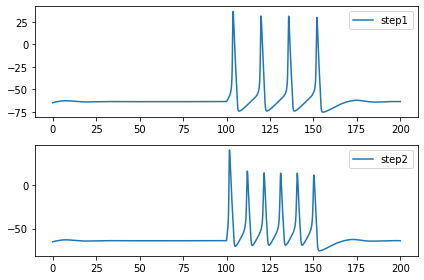

In [41]:
responses = twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict, sim=nrn)
print("Score: ", score_calc.calculate_scores(responses))
plot_responses(responses)

And indeed, as requested, the algorithm found a solution with 4 spikes in step1 and 6 spikes in step2

Let's have a look at the optimisation algorithm statistics.
We can plot the minimal score (sum of all objective scores) found in every generation. 

(0.0, 9.166666666666666)

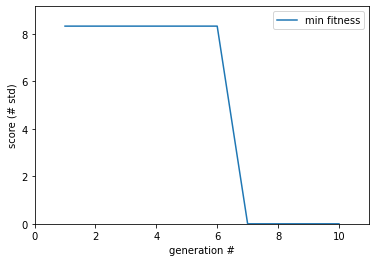

In [42]:
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

### Exercise 2:

Below is a copy of some of the above statements. Every variable has '\_ex' as suffix to prevent clashes with the code above.

Change the code in such a way that instead of the Spikecount feature, we search for a solution with AP_width of 1.3 in step1 and AP_width of 1.6 in step2.

Send us back the scores of the best individual found by the algorithm

Best individual:  [0.0363449854147152, 0.01570030612140416]
[1.1375515913851603e-12, 1.1379786002407853e-12]


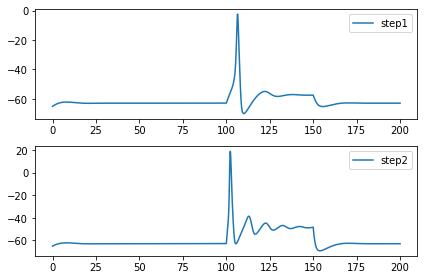

In [44]:
efel_feature_means_ex = {'step1': {'AP_width': 1.3}, 
                         'step2': {'AP_width': 1.6}}
objectives_ex = []
features_ex = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means_ex[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean))
        features_ex.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives_ex.append(objective)
        
score_calc_ex = ephys.objectivescalculators.ObjectivesCalculator(objectives_ex)

cell_evaluator_ex = ephys.evaluators.CellEvaluator(
        cell_model=ballandstick_cell,
        param_names=['gnabar_soma', 'gkbar_soma'],
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc_ex,
        sim=nrn)

optimisation_algorithm_ex = bpop.deapext.optimisations.IBEADEAPOptimisation(
        evaluator=cell_evaluator_ex,
        offspring_size = 10)

final_pop_ex, hall_of_fame_ex, logs_ex, hist_ex = optimisation_algorithm_ex.run(max_ngen=10)

best_ind_ex = hall_of_fame_ex[0]
print('Best individual: ', best_ind_ex)

best_ind_dict_ex = cell_evaluator.param_dict(best_ind_ex)
print(cell_evaluator_ex.evaluate_with_lists(best_ind_ex))

plot_responses(twostep_protocol.run(cell_model=ballandstick_cell, param_values=best_ind_dict_ex, sim=nrn))

In [47]:
responses = twostep_protocol.run(cell_model=ballandstick_cell, 
                                 param_values=best_ind_dict_ex, 
                                 sim=nrn)
print("Score: ", score_calc_ex.calculate_scores(responses))

Score:  {'step1.AP_width': 1.1375515913851603e-12, 'step2.AP_width': 1.1379786002407853e-12}
